In [84]:
Ns=4 #only even numbers
N, PBC = 3, False
J, U,V = 1, 40,-1.97
Nf = 800
maxInd = 2

In [85]:
from numpy import zeros, sqrt, linalg, array, ones, exp, eye, copy,sign,real,imag,transpose,log,average, var, conj, math, var,append, sort
import matplotlib.pyplot as plt
from random import randint
from scipy.sparse import lil_matrix
from scipy.optimize import basinhopping, dual_annealing, shgo, direct, brute, differential_evolution, minimize
from scipy.sparse.linalg import eigsh
import time

base, baseQ1, NoS = [], [], 0
base1, base1Q1, NoS1 = [],[],0
base2, base2Q1, NoS2 = [],[],0

for j1 in range(0,Ns):
        base1.append([0]*Ns)
        base1[-1][j1]+=1
        base1Q1.append([j1])
NoS1 = len(base1)

for j1 in range(0,Ns):
    for j2 in range(j1,Ns):
        base2.append([0]*Ns)
        base2[-1][j1]+=1
        base2[-1][j2]+=1
        base2Q1.append([j1,j2])
NoS2 = len(base2)

if N==2:
    for j1 in range(0,Ns):
        for j2 in range(j1,Ns):
            base.append([0]*Ns)
            base[-1][j1]+=1
            base[-1][j2]+=1
            baseQ1.append([j1,j2])
    NoS = len(base)

if N==3:
    for j1 in range(0,Ns):
        for j2 in range(j1,Ns):
            for j3 in range(j2,Ns):
                base.append([0]*Ns)
                base[-1][j1]+=1
                base[-1][j2]+=1
                base[-1][j3]+=1
                baseQ1.append([j1,j2,j3])
    NoS = len(base)

if N==4:
    for j1 in range(0,Ns):
        for j2 in range(j1,Ns):
            for j3 in range(j2,Ns):
                for j4 in range(j3,Ns):
                    base.append([0]*Ns)
                    base[-1][j1]+=1
                    base[-1][j2]+=1
                    base[-1][j3]+=1
                    base[-1][j4]+=1
                    baseQ1.append([j1,j2,j3,j4])
    NoS = len(base)
       
if N==5:
    for j1 in range(0,Ns):
        for j2 in range(j1,Ns):
            for j3 in range(j2,Ns):
                for j4 in range(j3,Ns):
                    for j5 in range(j4,Ns):
                        base.append([0]*Ns)
                        base[-1][j1]+=1
                        base[-1][j2]+=1
                        base[-1][j3]+=1
                        base[-1][j4]+=1
                        base[-1][j5]+=1
                        baseQ1.append([j1,j2,j3,j4,j5])
    NoS = len(base)
    
if N==6:
    for j1 in range(0,Ns):
        for j2 in range(j1,Ns):
            for j3 in range(j2,Ns):
                for j4 in range(j3,Ns):
                    for j5 in range(j4,Ns):
                        for j6 in range(j5,Ns):
                            base.append([0]*Ns)
                            base[-1][j1]+=1
                            base[-1][j2]+=1
                            base[-1][j3]+=1
                            base[-1][j4]+=1
                            base[-1][j5]+=1
                            base[-1][j6]+=1
                            baseQ1.append([j1,j2,j3,j4,j5,j6])
    NoS = len(base)
    
if Nf == "max":
    Nf = NoS
print('Number of base states =',NoS)

Number of base states = 20


In [86]:
#################################################################
##Compute energy and the GS of H for choosen N ##################
#################################################################

def generateHamitlonian(base_, J_,U_,V_):
    NoS = len(base_)
    H = lil_matrix((NoS,NoS),dtype=float)
    for i in range(NoS):
        sL = base_[i]

        for j in range(0,Ns-1):
            if sL[j]>0:
                coef = -J_*sqrt(sL[j])*sqrt(sL[j+1]+1)
                sR = [x for x in sL]
                sR[j]-=1
                sR[j+1]+=1
                ip = base_.index(sR)
                H[i,ip]+=coef
                H[ip,i]+=coef
        if PBC:     
            if sL[Ns-1]>0:
                coef = -J_*sqrt(sL[Ns-1])*sqrt(sL[0]+1)
                sR = [x for x in sL]
                sR[Ns-1]-=1
                sR[0]+=1
                ip = base_.index(sR)
                H[i,ip]+=coef
                H[ip,i]+=coef

        coefU = 0.0
        for j in range(0,Ns):
            coefU += 0.5*U_*sL[j]*(sL[j]-1)
        H[i,i] += coefU

        coefV = 0.0
        for j in range(0,Ns-1):
            coefV += V_*sL[j]*sL[j+1]
        if PBC:  
            coefV += V_*sL[Ns-1]*sL[0]
        H[i,i] += coefV
    return H

print("Computing reference 1- and 2-body GS...",end='')
t0 = time.time()

H_1atom = generateHamitlonian(base1, J,U,V)
E, v = eigsh(H_1atom,k=1,which='SA')  
E_1atom = E[0]
GS_1atom = sign(v[0,0])*v[:,0]

H_2atom = generateHamitlonian(base2, J,U,V)
E, v = eigsh(H_2atom,k=1,which='SA')  
E_2atom = E[0]
GS_2atom = sign(v[0,0])*v[:,0]


print(" DONE in ",(time.time()-t0)*1000,"[ms]")

Computing reference 1- and 2-body GS... DONE in  2.094268798828125 [ms]


In [88]:
###############################################################
##Tutaj szukamy najwazniejszych fockow w anzacu jastrowa#######
###############################################################
print(log(GS_2atom))
mapJ = {}
mapJR = {}

k=0
for i1 in range(Ns):
    for i2 in range(i1,Ns):
        mapJ[GS_2atom[k]] = [i1,i2]
        mapJR[i1*Ns+i2] = GS_2atom[k]
        mapJR[i2*Ns+i1] = GS_2atom[k]
        k+=1
mapJ = dict(sorted(mapJ.items(),reverse = True))        
print(mapJ)
mapJv = list(mapJ.values())
mapJk = list(mapJ.keys())
jsss = []
jss = {}
coefs = []

#print(len(mapJv))
#print(len(base))

def addJ(js_,multip_):
    if len(js_)==N:
        jsNew = list(sort(js_))
      #  if not jsNew.all() in jss:
        if not jsNew in jsss:
            jss[multip_]=jsNew
            jsss.append(jsNew)
            if len(jss) > Nf:
                #sort(jss)
                jssSorted = dict(sorted(jss.items(),reverse = True))  
                jssSorted.popitem()
                jss.clear()
                jss.update(jssSorted)
            
            
            #coefs.append(multip_)
    tmp = {}
    ind = 0
    for j in range(0,Ns):
        if not j in js_:
            mult = 1
            for jp in js_:
                mult*= mapJR[j*Ns+jp]
            tmp[mult] = j
    tmp = dict(sorted(tmp.items(),reverse = True))
    tmpv = list(tmp.values())
    tmpk = list(tmp.keys())
    for i in range(len(tmpv)):
        ind+=1
        if ind > maxInd:
            break
        j = tmpv[i]
        mult = tmpk[i]
        addJ(js_+[j],mult)
#print(mapJv)
#print(mapJv)
for i in range(min(maxInd,len(mapJv))):
    js = mapJv[i]
    mult = mapJk[i]
    addJ(js,mult)
    

jss = dict(sorted(jss.items(),reverse = True))    
#print(len(jss))
#print(jss)
#print(coefs)
jssv = list(jss.values())
jssk = list(jss.keys())
#print(len(mapJv))

[-4.49949851 -1.07887338 -0.97713085 -1.46531659 -3.42509396 -0.42226118
 -0.97713085 -3.42509396 -1.07887338 -4.49949851]
{0.6555627964591886: [1, 2], 0.376389468670121: [0, 2], 0.37638946867011974: [1, 3], 0.33997833487628765: [0, 1], 0.33997833487628254: [2, 3], 0.2310048457566134: [0, 3], 0.03254622270808005: [1, 1], 0.03254622270807994: [2, 2], 0.011114569006267616: [0, 0], 0.011114569006267505: [3, 3]}


In [81]:
unusedCombs = [x for x in mapJv]
def findUnusedSombs():
    for jsv in jssv:
        for i in range(len(jsv)-1):
            for ip in range(i+1,len(jsv)): 
                if [jsv[i],jsv[ip]] in unusedCombs:
                    unusedCombs.remove([jsv[i],jsv[ip]])
findUnusedSombs()
#print(unusedCombs)

def multipOfElem(js):
    out = 1
    for i in range(len(js)-1):
        for ip in range(i+1,len(js)):
            out*=  mapJR[js[i]*Ns+js[ip]]
    return out
print('Nf before:',len(jssv))    
for unusedComb in unusedCombs:
    val = [x for x in jssv[0]]
    val[0] = unusedComb[0]
    val[1] = unusedComb[1]
    jss[ multipOfElem(val) ] = val
    
    val = [x for x in jssv[4]]
    val[0] = unusedComb[0]
    val[1] = unusedComb[1]
    jss[ multipOfElem(val) ] = val
    
    val = [x for x in jssv[7]]
    val[0] = unusedComb[0]
    val[1] = unusedComb[1]
    jss[ multipOfElem(val) ] = val
    
    val = [x for x in jssv[11]]
    val[0] = unusedComb[0]
    val[1] = unusedComb[1]
    jss[ multipOfElem(val) ] = val
    
jssv = list(jss.values())
jssk = list(jss.keys())
Nf = len(jssv)   
#print(jssv)
print('Nf:',Nf)
#findUnusedSombs()
#print(unusedCombs)
        

# for i in range(len(jssv)):
#     print(jssv[i],jssk[i])
# plt.plot(list(jss.keys()))
# plt.grid()

Nf before: 4


IndexError: list index out of range

In [ ]:
def secondToFirst(state):
    baseState = state.copy()
    js = [0]*N
    for i in range(N):
        for n in range(Ns):
            if baseState[n]>0:
                js[i]=n
                baseState[n]-=1
                break
    return js

def norm(fock):
    out = math.factorial(N)
    for n in range(Ns):
        out /= math.factorial(fock[n])
    return sqrt(out)

def energy(c):
    return sum(real(conj(c)*H*c))

def getNis(c):
    out = zeros(Ns)
    for i in range(NoS):
        out += abs(c[i])**2*array(base[i])
    return out   

def getG2sX(c,x):
    G2s = zeros(Ns,dtype=complex)
    for i in range(NoS):
        fock = base[i]
        for xp in range(Ns):
            G2s[xp] += abs(c[i])**2*fock[x]*fock[xp]
            if x==xp:
                G2s[xp] -= abs(c[i])**2*fock[x]
    return G2s  

In [ ]:
def firstToSecond(js):
    out = zeros(Ns,dtype=int)
    for j in js:
        out[j]+=1
    return out

def P1(js):
    out = zeros(int(Ns*(Ns+1)/2),dtype=int)
    for n in range(N):
        for np in range(n+1,N):
            out[combs.index([js[n],js[np]])]+=1
    return out

def Ph1(js):
    out = zeros(len(combsh),dtype=int)
    for n in range(N):
        for np in range(n+1,N):
            ind1 = js[n]
            ind2 = js[np]
            if js[n]+js[np] >= Ns:
                ind1 -= (js[n]+js[np]-Ns+1)
                ind2 -= (js[n]+js[np]-Ns+1)
            out[combsh.index([ind1,ind2])]+=1
    return out

def P(fockState):
    js = secondToFirst(fockState)
    out = zeros(int(Ns*(Ns+1)/2),dtype=int)
    for n in range(N):
        for np in range(n+1,N):
            out[combs.index([js[n],js[np]])]+=1
    return out

def Ph(fockState):
    js = secondToFirst(fockState)
    out = zeros(len(combsh),dtype=int)
    for n in range(N):
        for np in range(n+1,N):
            ind1 = js[n]
            ind2 = js[np]
            if js[n]+js[np] >= Ns:
                ind1 -= (js[n]+js[np]-Ns+1)
                ind2 -= (js[n]+js[np]-Ns+1)    
            out[combsh.index([ind1,ind2])]+=1
    return out


In [ ]:
import random
import subprocess
import numpy as np




combs = []
for n in range(Ns):
    for n2 in range(n, Ns):
        combs.append([n,n2])
        
combsh = []
for n in range(Ns):
    for n2 in range(n, Ns):
        if n+n2 < Ns:
            combsh.append([n,n2])
print("Num lencobmsh:",len(combsh))
Norms1 = []
for i in range(NoS):
    Norms1.append( norm(base[i]) )
            
Norms1f = []
A1f = zeros([Nf,int((Ns+1)/2)],dtype=int)
A2hf = zeros([Nf,len(combsh)],dtype=int)
GS_Rf = zeros(Nf)


file = open("../DMRG/Js.txt",'w')

print("Generating matrix A...",end='')
t0 = time.time()

jss = jssv
for js in jss:
    for j in js:
        file.write(str(j)+" ")
    file.write("\n")       
file.close()

# jss = []
# for i in range(Nf):
#     js = []
#     js.append(combsh[i%len(combsh)][0])
#     js.append(combsh[i%len(combsh)][1])
#     for ip in range(2,N):
#         js.append(random.randint(0,Ns-1))
#     js.sort()
    
#     while js in jss:
#         js = []
#         js.append(combsh[i%len(combsh)][0])
#         js.append(combsh[i%len(combsh)][1])
#         for ip in range(2,N):
#             js.append(random.randint(0,Ns-1))
#         js.sort()
#    # print(js)
#     for j in js:
#         file.write(str(j)+" ")
#     file.write("\n")
#     jss.append(js)
# file.close()



maxOcc = min(N,5)
#maxOcc = 3
result = str(subprocess.run(['../DMRG/build_getter/job', 'Ns{i}='+str(Ns), 'N{i}='+str(N), 'U{f}='+str(U), 'V{f}='+str(V), 'MaxOcc{i}='+str(maxOcc), 'Nf{i}='+str(Nf)], stdout=subprocess.PIPE)).split("\\n")
G1Ref = np.loadtxt("G1.txt")
G2Ref = np.loadtxt("G2.txt")
print(" DONE in ",(time.time()-t0)*1000,"[ms]")
#plt.plot([G1Ref[i,i] for i in range(Ns)])
for i in range(1,len(result)-2):
    GS_Rf[i-1] = float(result[i])
        
intt = 0
for i in range(len(jss)):
   # print(jss[i])
    js = jss[i]
    fock = firstToSecond(js)
    A1f[i] = array(fock[0:int((Ns+1)/2)])  + array(fock[Ns:int((Ns-1)/2):-1])
    A2hf[i] = Ph1(js)
    Norms1f.append( norm(firstToSecond(js)) )
    intt+=1
    
#############################################################################################
 
def psi12to14(psi12):
    out = []
    num =0
    for comb in combs:
        if comb[0]+comb[1]< Ns:
            out.append(psi12[num])
        num+=1
    return array(out)

def psi14to12(psi14):
    out = zeros(len(combs))
    num =0
    for combh in combsh:
        ind1 = combh[0]
        ind2 = combh[1]
        out[combs.index([ind1,ind2])] = psi14[num]
        
        ind1 += Ns-1-(combh[0]+combh[1])
        ind2 += Ns-1-(combh[0]+combh[1])
        out[combs.index([ind1,ind2])] = psi14[num]
        num+=1      
    return out
     
##############################################################################################

Norms_2atom = []
for i in range(len(base2)):
    Norms_2atom.append( norm(base2[i]) )



def variance1h( psi ):
    c = normalised(real(array(Norms1)*exp(A1.dot(log(psi,dtype=complex)))))
    return sum((c-GS)**2)

def variance1hf( psi ):
    c = normalised(real(array(Norms1f)*exp(A1f.dot(log(psi,dtype=complex)))))
    return sum((c-GS_Rf)**2)

def findPsi1(method='half'):
    print("Looking for Psi_A1...",end='')
    minimizer_kwargs = {"method": "COBYLA"}
    t0 = time.time()
    psi0h = GS_1atom[0:int((Ns+1)/2)]
    reth = basinhopping(variance1h, psi0h, minimizer_kwargs=minimizer_kwargs, niter=100,niter_success=10)
    psi = append(reth.x, reth.x[::-1])
    print(" DONE in",(time.time()-t0)*1000,"[ms]")
    return psi

def findPsi1f(method='half'):
    print("Looking for Psi_A1f...",end='')
    minimizer_kwargs = {"method": "COBYLA"}
    t0 = time.time()
    psi0h = GS_1atom[0:int((Ns+1)/2)]
    reth = basinhopping(variance1hf, psi0h, minimizer_kwargs=minimizer_kwargs, niter=100,niter_success=10)
    psi = append(reth.x, reth.x[::-1])
    print(" DONE in",(time.time()-t0)*1000,"[ms]")
    return psi

In [ ]:
####################################################
## Functions for Ansatz 2 ##########################
####################################################

def normalised(arr):
    return arr / sqrt(sum(abs(arr)**2))

def variance2h( psi ):
    c = normalised(real(array(Norms1)*exp(A2h.dot(log(psi,dtype=complex)))))
    return sum((c-GS)**2)

def variance2hf( psi ):
    c = normalised(real(array(Norms1f)*exp(A2hf.dot(log(psi,dtype=complex)))))
    return sum((c-GS_Rf)**2)

def findPsi2():
    print("Looking for Psi_A2...",end='')
    t0 = time.time()
    psi0 = GS_2atom
    ret = minimize(variance2, psi0, method='Powell', tol=1e-12, bounds=[(1e-12,1)]*len(psi0))
    print(" DONE in",(time.time()-t0)*1000,"[ms]")
    return ret.x

def findPsi2f():
    print("Looking for Psi_A2f...",end='')
    t0 = time.time()
    psi0 = GS_2atom
    ret = minimize(variance2f, psi0, method='Powell', tol=1e-12, bounds=[(1e-12,1)]*len(psi0))
    print(" DONE in",(time.time()-t0)*1000,"[ms]")
    return ret.x

def findPsi2h():
    print("Looking for Psi_A2...",end='')
    t0 = time.time()
    psi0 = psi12to14(GS_2atom)
    ret = minimize(variance2h, psi0, method='Powell', tol=1e-18, bounds=[(1e-12,1)]*len(psi0))
    print(" DONE in",(time.time()-t0)*1000,"[ms]")
    return psi14to12(ret.x)

def findPsi2hf():
    print("Looking for Psi_A2f...",end='')
    t0 = time.time()
    psi0 = psi12to14(GS_2atom)
    ret = minimize(variance2hf, psi0, method='Powell', tol=1e-18, bounds=[(1e-12,1)]*len(psi0))
    print(" DONE in",(time.time()-t0)*1000,"[ms]")
    return psi14to12(ret.x)

def reshapePhiTo2D(phi1D):
    out = zeros([Ns,Ns],dtype=complex)
    num=0
    for n in range(Ns):
        out[n][n] = phi1D[num]
        num+=1
        for n2 in range(n+1, Ns):
            out[n][n2] = phi1D[num]
            out[n2][n] = phi1D[num]
            num+=1
    return out


In [ ]:
A1 = zeros([NoS,int((Ns+1)/2)],dtype=int)

for i in range(NoS):
    A1[i] = array(base[i][0:int((Ns+1)/2)])  + array(base[i][Ns:int((Ns-1)/2):-1])

A2 = zeros([NoS,len(combs)],dtype=int)
A2h = zeros([NoS,len(combsh)],dtype=int)


for i in range(NoS):
    A2[i] = P(base[i])
    A2h[i] = Ph(base[i])


####################################################
## Compute best Ansatz functions ###################
####################################################
psiA1f = findPsi1f()
phiA21Df = findPsi2hf()

phiA2f = reshapePhiTo2D(phiA21Df)

In [ ]:
####################################################
## Plot Ansatz functions ###########################
####################################################

import numpy as np
phiJ = reshapePhiTo2D(GS_2atom)

psiA1f /= sqrt(sum(abs(psiA1f)**2))

phiA21Df /= sqrt(sum(sum(abs(phiA2f)**2)))
phiA2f /= sqrt(sum(sum(abs(phiA2f)**2)))
phiJ /= sqrt(sum(sum(abs(phiJ)**2)))

#print('|<ED|A2>|^2 = ',1-0.5*variance1h(psiA1f))
print('e^{ln(|<ED|A2>|^2)/N} = ',exp(log(1-0.5*variance2hf(psi12to14(phiA21Df)))/N))
#print('|<ED|J>|^2 = ',1-0.5*variance2h(phiJ))
#print()

fig, ax = plt.subplots(2,3,figsize=(9,5.5))
fig.suptitle("N=%i, N$_s$=%i, N$_f$=%i,  J=%f, U=%f, V=%f" % (N, Ns, Nf,J,U,V))
ax[0,0].plot(real(psiA1f),label='Re')
ax[0,0].plot(imag(psiA1f),label='Im')

cmap = ax[0,1].imshow(real(phiA2f))
cbar = plt.colorbar(cmap)

cmap = ax[0,2].imshow(imag(phiA2f))
cbar = plt.colorbar(cmap)

cmap = ax[1,1].imshow(real(phiJ))
cbar = plt.colorbar(cmap)
cmap = ax[1,2].imshow(imag(phiJ))
cbar = plt.colorbar(cmap)

ax[1,0].plot([real(phiA2f)[i,i] for i in range(Ns)],label='diag')
ax[1,0].plot([real(phiA2f)[i,Ns-1-i] for i in range(Ns)],label='anty-diag')
ax[1,0].plot([real(phiA2f)[int(Ns/2),i] for i in range(Ns)],label='horizontal')

ax[1,0].plot([real(phiJ)[i,i] for i in range(Ns)],'--',c='tab:blue')
ax[1,0].plot([real(phiJ)[i,Ns-1-i] for i in range(Ns)],'--',c='tab:orange')
ax[1,0].plot([real(phiJ)[int(Ns/2),i] for i in range(Ns)],'--',c='tab:green')


ax[1,0].legend()
ax[0,0].grid()
ax[1,0].grid()
ax[0,0].legend()
ax[1,0].set_xlabel('Lattice site (i)')
ax[0,1].set_ylabel('Lattice site (j)')

ax[0,0].set_title('$\phi_1(i)$')
ax[0,1].set_title('$Re[\phi_{2}(i,j)]$')
ax[0,2].set_title('$Im[\phi_{2}(i,j)]$')

ax[1,1].set_xlabel('Lattice site (i)')
ax[1,1].set_ylabel('Lattice site (j)')
ax[1,2].set_xlabel('Lattice site (i)')

ax[1,1].set_title('$Re[\phi_J(i,j)]$')
ax[1,2].set_title('$Im[\phi_J(i,j)]$')
plt.tight_layout()
np.save(("Ns%i_N%i_J%f_U%f_V%f_Nf%i"%(Ns,N,J,U,V,Nf)),real(phiA2f))
plt.savefig("Ns%i_N%i_J%f_U%f_V%f_Nf%i.png"%(Ns,N,J,U,V,Nf))
plt.show()

In [74]:
from sympy.utilities.iterables import multiset_permutations
from operator import itemgetter
from numpy import outer, sort, concatenate
from numpy.linalg import svd
from math import factorial
from itertools import permutations
from time import sleep

u, λ, v =svd(real(phiA2f**2), full_matrices=True)

λ*=-1
λ[0]*=-1


In [75]:
NCombs = []
for i in range(0,N):
    for j in range(i+1,N):
        NCombs.append([i,j])

def Λ(ls):
    out = 1
    for l in ls:
        out *= λ[l]
    return out

def f(l,num):
    out = []
    for i in range(len(NCombs)):
        if num in NCombs[i]:
            out.append(l[i])
    return array(out)

def B(fl):
    out = 1
    for k in range(0,N-1):
        out *= u[:,fl[k]]
    return out

def Γ(fl):
    return sum(B(fl))

factorialNCombs = factorial(len(NCombs))


def gen_N_G2(l):    
    outN = zeros(Ns,dtype=float)
    outG2 = zeros((Ns,Ns),dtype=float)
    for σl in multiset_permutations(l): 
        multip = 1    
        for i in range(2,N):
            multip *= Γ(f(σl,i))
            
        outN += B(f(σl,0))*Γ(f(σl,1)) * multip
        outG2 += outer( array(B(f(σl,0))) , array(B(f(σl,1))) ) * multip
    return factorialNCombs*Λ(l)*outN, factorialNCombs*Λ(l)*outG2

In [76]:
def keyToLs(key):
    out = [0]*len(NCombs)
    for i in range(0,len(NCombs)):
        out[len(NCombs)-1-i]=key%Ns
        key //= Ns
    return out

def lsToKey(ls):
    key = ls[0]
    for i in range(1,len(ls)):
        key*=Ns
        key+=ls[i]
    return key


ls = [0]*len(NCombs)
lss = {}

def numPerms(ls):
    out = 0
    for perm in multiset_permutations(ls):
        out+=1   
    return out

def numPermsB(ls):
    out = 1
    Na = 1
    slots = len(ls)
    lold = ls[0]
    for l in ls[1:]:
        if l != lold:
            out *= factorial(slots)/factorial(slots-Na)/factorial(Na)
            slots -= Na
            Na=1
            lold = l
        else:
            Na+=1
    return out

def appendL(i):
    if i == len(NCombs):
        key = lsToKey(ls)
        lss[key] = numPermsB(ls)*Λ(ls)
    else:
        for j in range(ls[i-1],Ns):
            ls[i]=j
            appendL(i+1)
            
print("Computing vaulues of combinations...",end='')
t0 = time.time()

for i0 in range(0,Ns):
    ls[0]=i0
    appendL(1)
print(" DONE in ",(time.time()-t0)*1000,"[ms]")        


lss = dict(sorted(lss.items(), key=lambda item: abs(item[1]),reverse=True))
keys = list(lss.keys())
coefs = list(lss.values())

Computing vaulues of combinations... DONE in  1.4142990112304688 [ms]


Computing N and G2.. DONE in  195.3449249267578 [ms]


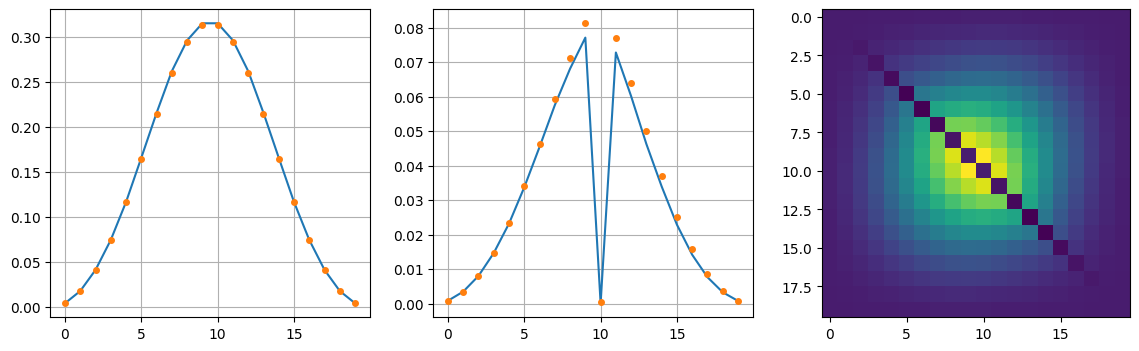

In [85]:
print("Computing N and G2..",end='')
t0 = time.time()


n,G2 = gen_N_G2(keyToLs(keys[0]))
for i in range(1,1540):
    [nup,G2up] = gen_N_G2(keyToLs(keys[i]))
    n+=nup
    G2+=G2up
    
print(" DONE in ",(time.time()-t0)*1000,"[ms]")

fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(real(n)*G1Ref[0,0]/real(n[0]),'-')
ax[0].plot([G1Ref[i,i] for i in range(Ns)],'o',label="ED",markersize=4)
ax[1].plot([G2[i,int(Ns/2)]*G2Ref[0,int(Ns/2)]/G2[0,int(Ns/2)] for i in range(Ns)],'-',label="math")
ax[1].plot(G2Ref[:,int(Ns/2)],'o',label="ED",markersize=4)
ax[2].imshow(G2)

ax[0].grid()
ax[1].grid()
plt.show()